In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# prompt: mount dataset present in drive at majorproject/FFE

!ln -s "/content/drive/My Drive/majorproject/FFE" /content/FFE

In [3]:
!pip install -q opencv-python matplotlib tensorflow seaborn
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

In [4]:
#XSFFE Preprocessing Steps Implemented:
# STEP 1: Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
from scipy.ndimage import distance_transform_edt

# STEP 2: Choose dataset ("Good" or "Bad")
dataset_type = "Good"  # change to "Bad" if needed
dataset_path = f"/content/FFE_data/{dataset_type}"

# STEP 3: Load fingerprint and segmentation images
fingerprint_files = sorted(glob(os.path.join(dataset_path, "/content/drive/MyDrive/majorproject/FFE/Good/119.png")))
segmentation_files = sorted(glob(os.path.join(dataset_path, "/content/drive/MyDrive/majorproject/FFE/Good/119.fg.png")))

print(f"✅ Found {len(fingerprint_files)} fingerprint files in '{dataset_type}'")

if len(fingerprint_files) == 0 or len(segmentation_files) == 0:
    raise FileNotFoundError("❌ No matching fingerprint or segmentation files found!")

# STEP 4: XSFFE Preprocessing Function
def preprocess_xsffe(image, segmentation_mask):
    # 1. Median Filtering
    median = cv2.medianBlur(image, 3)

    # 2. Gaussian Smoothing
    gaussian = cv2.GaussianBlur(median, (5, 5), 0)

    # 3. Foreground Masking
    masked = cv2.bitwise_and(gaussian, gaussian, mask=(segmentation_mask // 255).astype(np.uint8))

    # 4. Distance-based pixel filtering (retain only if >= 11 pixels from background)
    background_mask = (segmentation_mask == 0).astype(np.uint8)
    dist_transform = distance_transform_edt(1 - background_mask)
    valid_region = (dist_transform >= 11).astype(np.uint8) * 255

    filtered = cv2.bitwise_and(masked, masked, mask=valid_region)

    return filtered, masked, valid_region

# STEP 5: Process one example (index 0)
idx = 0
fp_img = cv2.imread(fingerprint_files[idx], cv2.IMREAD_GRAYSCALE)
seg_img = cv2.imread(segmentation_files[idx], cv2.IMREAD_GRAYSCALE)

# Preprocess
filtered_img, masked_img, dist_mask = preprocess_xsffe(fp_img, seg_img)

# STEP 6: Visualize steps
plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
plt.imshow(fp_img, cmap='gray')
plt.title("Original Fingerprint")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(masked_img, cmap='gray')
plt.title("Masked (Foreground)")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(dist_mask, cmap='gray')
plt.title("Distance >= 11 Pixels")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(filtered_img, cmap='gray')
plt.title("Final XSFFE Preprocessed")
plt.axis('off')

plt.tight_layout()
plt.show()


✅ Found 1 fingerprint files in 'Good'


In [5]:
pip install --upgrade albumentations


In [6]:
import albumentations as A
print(A.__version__)


2.0.8


In [7]:
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.8
    ),
    A.RandomGamma(p=0.4),
    A.RandomBrightnessContrast(p=0.4),
])


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 17.1 MB/s eta 0:00:00
Found 1 fingerprint sets in 'Good'


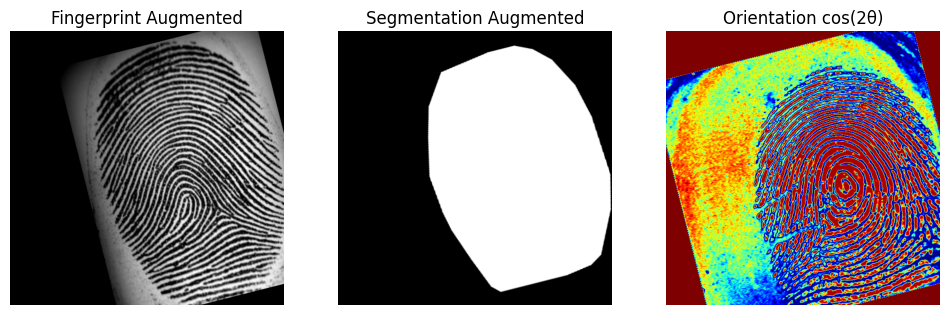

In [8]:
#Preprocessing for the SNFFE Deep Learning Method
!pip install albumentations==0.4.6 scikit-image opencv-python --quiet


import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import os
from glob import glob

# Choose between "Good" or "Bad"
dataset_type = "Good"
dataset_dir = f"/content/FFE_data/{dataset_type}"

# Collect file paths
fingerprints = sorted(glob(os.path.join(dataset_dir, "/content/drive/MyDrive/majorproject/FFE/Good/119.png")))
segmentations = sorted(glob(os.path.join(dataset_dir, "/content/drive/MyDrive/majorproject/FFE/Good/119.fg.png")))
orientations = sorted(glob(os.path.join(dataset_dir, "/content/drive/MyDrive/majorproject/FFE/Good/113.png")))

print(f"Found {len(fingerprints)} fingerprint sets in '{dataset_type}'")

# Resize and pad helper
def resize_and_pad(img, size=512):
    h, w = img.shape
    scale = size / max(h, w)
    new_h, new_w = int(h * scale), int(w * scale)
    img_resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    pad = np.zeros((size, size), dtype=np.uint8)
    pad[:new_h, :new_w] = img_resized
    return pad

# Augmentation pipeline—cleaned up
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    # A.Affine(scale=(0.9, 1.1), translate_percent=0.1, rotate=(-15, 15), p=0.8), # Removed Affine
    A.ShiftScaleRotate(
        shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.8
    ),
    A.RandomGamma(p=0.4),
    A.RandomBrightnessContrast(p=0.4),
    A.ElasticTransform(p=0.2),
    A.GridDistortion(p=0.2),
    A.GaussianBlur(p=0.2),
], additional_targets={"seg": "image", "ori": "image"})

# Process the first sample for preview
idx = 0
fp = cv2.imread(fingerprints[idx], cv2.IMREAD_GRAYSCALE)
seg = cv2.imread(segmentations[idx], cv2.IMREAD_GRAYSCALE)
ori = cv2.imread(orientations[idx], cv2.IMREAD_GRAYSCALE)

# Resize and pad
fp = resize_and_pad(fp)
seg = resize_and_pad(seg)
ori = resize_and_pad(ori)

# Apply augmentations
aug = augment(image=fp, seg=seg, ori=ori)
fp_aug = aug["image"]
seg_aug = aug["seg"]
ori_aug = aug["ori"]

# Encode orientation: 0-255 to radians, then cos(2θ)
theta = (ori_aug.astype(np.float32) / 255.0) * np.pi
X = np.cos(2 * theta)

# Combine into SNFFE input (3 channels)
snffe_input = np.stack([
    fp_aug.astype(np.float32) / 255.0,
    seg_aug.astype(np.float32) / 255.0,
    X
], axis=-1)

# Display
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(fp_aug, cmap='gray')
plt.title('Fingerprint Augmented')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(seg_aug, cmap='gray')
plt.title('Segmentation Augmented')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(X, cmap='jet')
plt.title('Orientation cos(2θ)')
plt.axis('off')
plt.show()

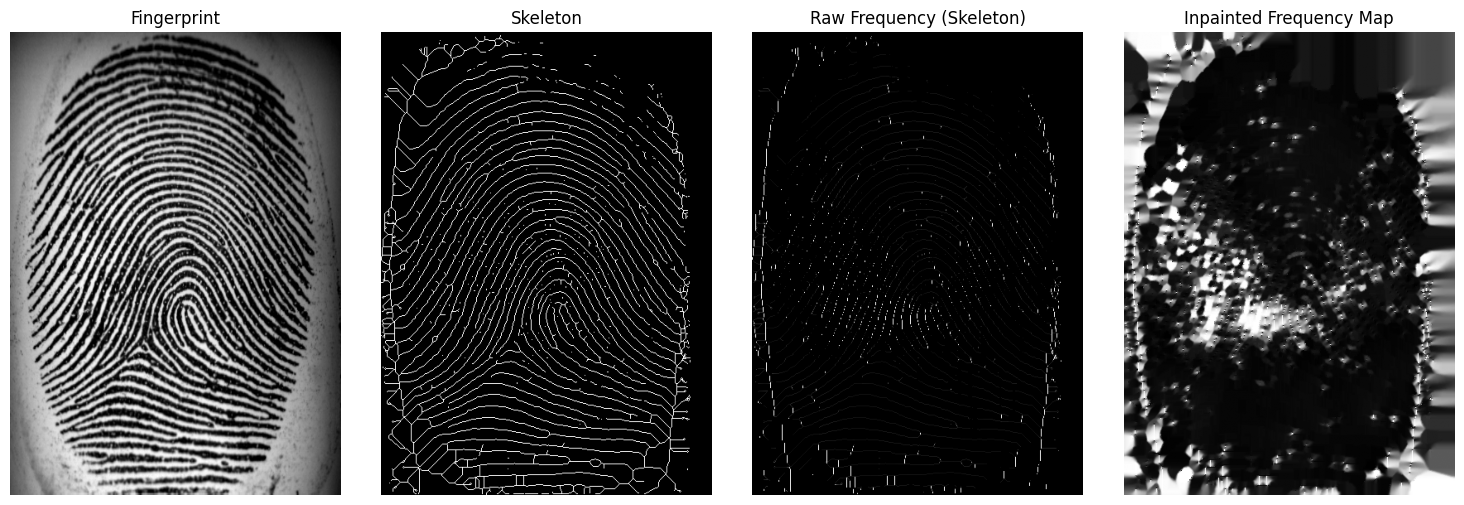

In [9]:
#Preprocessing for Ground Truth Generation
# STEP 1: Install missing libraries
!pip install scikit-image --quiet

# STEP 2: Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.filters import threshold_otsu
import os

# STEP 3: Load input images
# Replace these with your actual file paths
fingerprint = cv2.imread('/content/drive/MyDrive/majorproject/FFE/Good/119.png', cv2.IMREAD_GRAYSCALE)
orientation_img = cv2.imread('/content/drive/MyDrive/majorproject/FFE/Good/119.fg.png', cv2.IMREAD_GRAYSCALE)  # 0-255 encoding

# Check for loading errors
if fingerprint is None or orientation_img is None:
    raise FileNotFoundError("Make sure 'fingerprint.png' and 'orientation_field.png' are uploaded correctly.")

# STEP 4: Generate a binary skeleton from fingerprint (simulate manual markup)
threshold = threshold_otsu(fingerprint)
binary = fingerprint > threshold
skeleton = skeletonize(binary).astype(np.uint8) * 255

# STEP 5: Convert orientation field to radians (0-π)
orientation_radians = (orientation_img.astype(np.float32) / 255.0) * np.pi

# STEP 6: Compute frequency on skeleton
def compute_frequency_from_skeleton(fingerprint, orientation_field, skeleton):
    height, width = fingerprint.shape
    frequency_map = np.zeros((height, width), dtype=np.float32)
    ys, xs = np.where(skeleton > 0)

    for y, x in zip(ys, xs):
        theta = orientation_field[y, x]
        dx = np.cos(theta + np.pi / 2)
        dy = np.sin(theta + np.pi / 2)
        distances = []
        for sign in [-1, 1]:
            for d in range(1, 20):
                px = int(round(x + sign * d * dx))
                py = int(round(y + sign * d * dy))
                if 0 <= px < width and 0 <= py < height:
                    if skeleton[py, px] > 0:
                        distances.append(d)
                        break
        if len(distances) == 2:
            spacing = sum(distances)
            frequency_map[y, x] = 1.0 / spacing
    return frequency_map

raw_freq_map = compute_frequency_from_skeleton(fingerprint, orientation_radians, skeleton)

# STEP 7: Inpaint the frequency map using OpenCV
def inpaint_frequency_map(freq_map):
    mask = (freq_map == 0).astype(np.uint8) * 255
    freq_map_8bit = (freq_map * 255).astype(np.uint8)
    inpainted = cv2.inpaint(freq_map_8bit, mask, 3, cv2.INPAINT_NS)
    return inpainted.astype(np.float32) / 255.0

inpainted_freq_map = inpaint_frequency_map(raw_freq_map)

# STEP 8: Show results
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(fingerprint, cmap='gray')
plt.title('Fingerprint')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(skeleton, cmap='gray')
plt.title('Skeleton')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(raw_freq_map, cmap='gray')
plt.title('Raw Frequency (Skeleton)')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(inpainted_freq_map, cmap='gray')
plt.title('Inpainted Frequency Map')
plt.axis('off')

plt.tight_layout()
plt.show()


In [10]:
# ✅ Function to load and normalize fingerprint images
def load_and_normalize_images(folder_path, target_size=(256, 256)):
    images = []
    for filename in os.listdir(folder_path):
        # Corrected file extension check
        if filename.lower().endswith(('.png')):
            # Load grayscale image
            img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"⚠️ Skipping unreadable file: {filename}")
                continue

            # Resize image to standard size (e.g., 256x256)
            img = cv2.resize(img, target_size)

            # Normalize: scale pixel values to [0, 1]
            img = img.astype(np.float32) / 255.0

            images.append(img)
    return np.array(images)


# ✅ Define your dataset path and load
dataset_path = '/content/drive/MyDrive/majorproject/FFE/Good'  # Changed to include the 'Good' subdirectory
images = load_and_normalize_images(dataset_path)

print(f"✅ Loaded and normalized {len(images)} fingerprint images.")
if len(images) > 0:
  print(f"Example image shape: {images[0].shape}")

✅ Loaded and normalized 40 fingerprint images.
Example image shape: (256, 256)


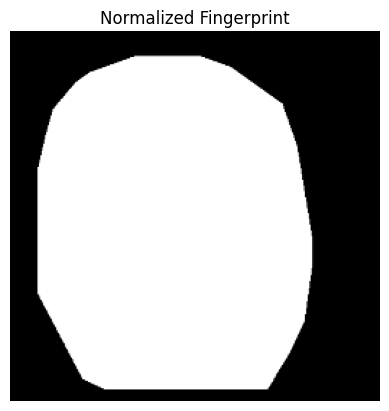

In [11]:
plt.imshow(images[0], cmap='gray')
plt.title("Normalized Fingerprint")
plt.axis('off')
plt.show()


In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ✅ Function to generate ROI mask using local variance
def segment_fingerprint_roi(image, block_size=16, threshold=0.1):
    h, w = image.shape
    mask = np.zeros((h, w), dtype=np.uint8)

    for y in range(0, h - block_size + 1, block_size):
        for x in range(0, w - block_size + 1, block_size):
            block = image[y:y+block_size, x:x+block_size]
            stddev = np.std(block)

            if stddev > threshold:
                mask[y:y+block_size, x:x+block_size] = 1

    # Morphological cleaning (dilation + erosion)
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

    return mask


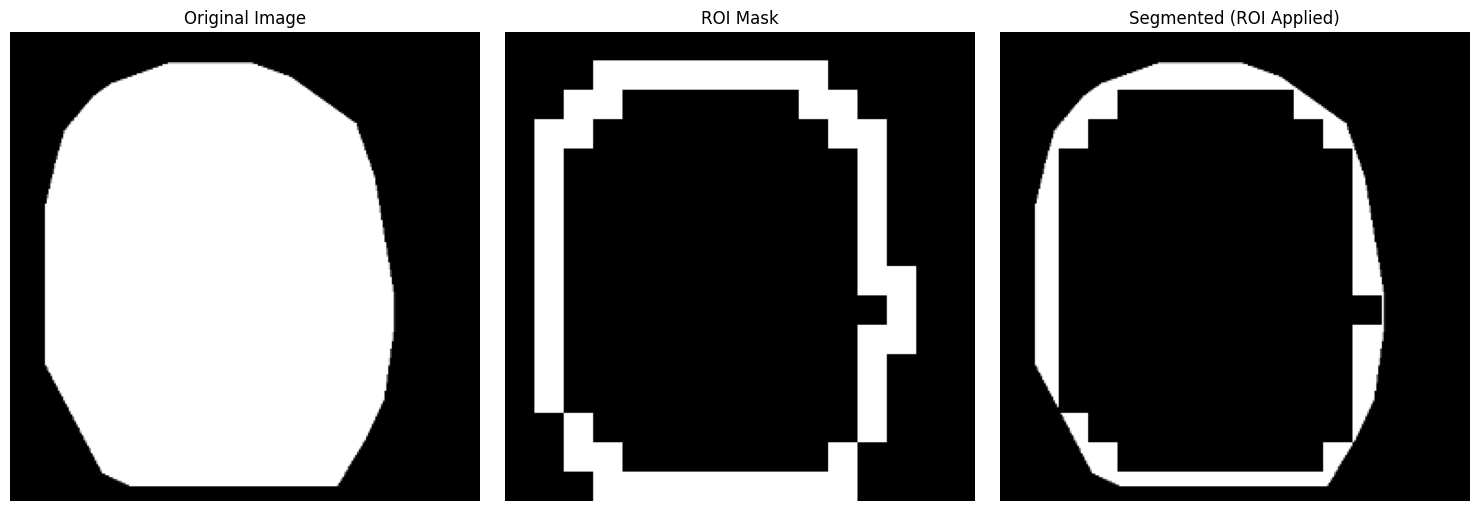

In [13]:
# ✅ Apply ROI segmentation to one fingerprint
img = images[0]  # select a normalized image from your dataset

roi_mask = segment_fingerprint_roi(img, block_size=16, threshold=0.05)

# Apply mask
masked_img = img * roi_mask

# Show result
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(roi_mask, cmap='gray')
plt.title("ROI Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(masked_img, cmap='gray')
plt.title("Segmented (ROI Applied)")
plt.axis('off')

plt.tight_layout()
plt.show()


In [14]:
#Gabor Filter-Based Enhancement (Preprocessing)
import cv2
import numpy as np
import matplotlib.pyplot as plt

def enhance_with_fixed_gabor(img, kernel_size=21, frequency=0.1, theta_deg=0):
    theta = np.deg2rad(theta_deg)  # Convert angle to radians
    sigma = 4.0
    lamda = 1.0 / frequency
    gamma = 0.5
    psi = 0

    gabor_kernel = cv2.getGaborKernel((kernel_size, kernel_size), sigma, theta, lamda, gamma, psi, ktype=cv2.CV_32F)
    enhanced_img = cv2.filter2D(img, cv2.CV_32F, gabor_kernel)

    return enhanced_img


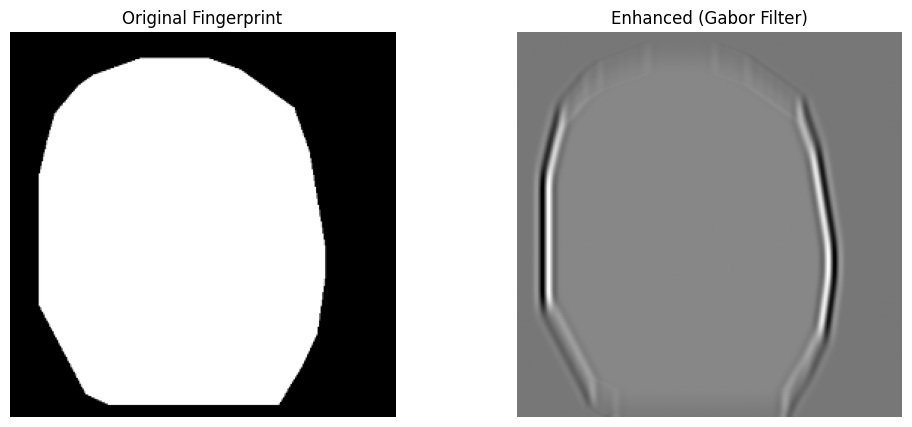

In [15]:
#Apply Enhancement and Visualize
# Select a normalized fingerprint image
img = images[0]

# Enhance with Gabor (fixed orientation and frequency for now)
enhanced = enhance_with_fixed_gabor(img, kernel_size=21, frequency=0.12, theta_deg=0)

# Normalize output for display
enhanced_norm = cv2.normalize(enhanced, None, 0, 1, cv2.NORM_MINMAX)

# Plot original and enhanced
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Fingerprint")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(enhanced_norm, cmap='gray')
plt.title("Enhanced (Gabor Filter)")
plt.axis('off')

plt.show()


In [16]:
#Apply Gabor in Multiple Orientations (Multi-directional Enhancement)
def multi_orientation_enhancement(img, orientations=[0, 30, 60, 90, 120, 150], frequency=0.1):
    accum = np.zeros_like(img, dtype=np.float32)
    for theta in orientations:
        enhanced = enhance_with_fixed_gabor(img, frequency=frequency, theta_deg=theta)
        accum += enhanced
    return cv2.normalize(accum, None, 0, 1, cv2.NORM_MINMAX)


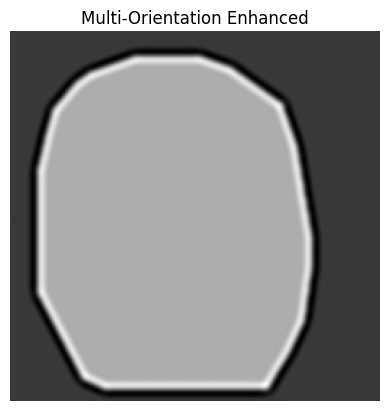

In [17]:
enhanced_multi = multi_orientation_enhancement(img, orientations=[0, 30, 60, 90, 120, 150])

plt.imshow(enhanced_multi, cmap='gray')
plt.title("Multi-Orientation Enhanced")
plt.axis('off')
plt.show()


In [18]:
#Patch Extraction (32×32 with Stride)
def extract_patches(image, patch_size=32, stride=32):
    """
    Extracts non-overlapping or overlapping patches from an image.
    """
    patches = []
    h, w = image.shape
    if h < patch_size or w < patch_size:
        return []  # Skip if image is too small

    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch = image[y:y + patch_size, x:x + patch_size]
            patches.append(patch)
    return patches


In [19]:
# Example: Extract 32×32 patches from all normalized images
all_patches = []

for i, img in enumerate(images):  # assuming `images` is your dataset
    patches = extract_patches(img, patch_size=32, stride=32)
    if len(patches) == 0:
        print(f"⚠️ Skipping image {i}: too small or no patches extracted.")
    else:
        all_patches.extend(patches)

# Convert to numpy array and add channel dimension
all_patches = np.array(all_patches)[..., np.newaxis]  # shape: (num_patches, 32, 32, 1)

print("✅ Total patches extracted:", all_patches.shape)


✅ Total patches extracted: (2560, 32, 32, 1)


In [20]:
#Adaptive CNN Architecture
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model

def build_adaptive_cnn(input_shape=(32, 32, 1), ori_classes=18, freq_classes=10):
    inputs = Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Shared feature vector
    shared = layers.Dense(128, activation='relu')(x)

    # Orientation head
    ori_output = layers.Dense(ori_classes, activation='softmax', name='orientation')(shared)

    # Frequency head
    freq_output = layers.Dense(freq_classes, activation='softmax', name='frequency')(shared)

    model = Model(inputs=inputs, outputs=[ori_output, freq_output])
    return model


In [21]:
#Compile the Model
model = build_adaptive_cnn(input_shape=(32, 32, 1), ori_classes=18, freq_classes=10)

model.compile(optimizer='adam',
              loss={'orientation': 'categorical_crossentropy', 'frequency': 'categorical_crossentropy'},
              metrics={'orientation': 'accuracy', 'frequency': 'accuracy'})

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 128) │     73,856 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ orientation (Dense) │ (None, 18)        │      2,322 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ frequency (Dense)   │ (None, 10)        │      1,290 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 113,692 (444.11 KB)

 Trainable params: 113,244 (442.36 KB)

 Non-trainable params: 448 (1.75 KB)

In [22]:
#Generate Dummy Labels and Split Data
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# ✅ Assume patches are already extracted
num_patches = all_patches.shape[0]

# ✅ Set number of classes
num_ori_classes = 18
num_freq_classes = 10

# ✅ Generate random class labels
ori_labels = np.random.randint(0, num_ori_classes, size=num_patches)
freq_labels = np.random.randint(0, num_freq_classes, size=num_patches)

# ✅ Convert to one-hot encoded labels
orientation_labels = to_categorical(ori_labels, num_classes=num_ori_classes)
frequency_labels = to_categorical(freq_labels, num_classes=num_freq_classes)

# ✅ Train-validation split
X_train, X_val, y_ori_train, y_ori_val, y_freq_train, y_freq_val = train_test_split(
    all_patches, orientation_labels, frequency_labels, test_size=0.2, random_state=42
)

print("✅ Shapes:")
print("X_train:", X_train.shape)
print("y_ori_train:", y_ori_train.shape)
print("y_freq_train:", y_freq_train.shape)


✅ Shapes:
X_train: (2048, 32, 32, 1)
y_ori_train: (2048, 18)
y_freq_train: (2048, 10)


In [23]:
#Training adaptive CNN model
history = model.fit(
    X_train, {'orientation': y_ori_train, 'frequency': y_freq_train},
    validation_data=(X_val, {'orientation': y_ori_val, 'frequency': y_freq_val}),
    epochs=10,  # adjust as needed
    batch_size=64
)


Epoch 1/10
12/32 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - frequency_accuracy: 0.0876 - frequency_loss: 2.4205 - loss: 5.4296 - orientation_accuracy: 0.0534 - orientation_loss: 3.0091

KeyboardInterrupt: 

In [24]:
#Save the Trained Model
model.save('/content/adaptive_cnn_fingerprint.h5')
print("✅ Model saved successfully!")


✅ Model saved successfully!


In [25]:
#Load the Saved Model
from tensorflow.keras.models import load_model

# ✅ Path where you saved the model
model_path = '/content/adaptive_cnn_fingerprint.h5'

# ✅ Load the model
loaded_model = load_model(model_path)

# ✅ Verify it's loaded
loaded_model.summary()
print("✅ Model loaded successfully!")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 128) │     73,856 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ orientation (Dense) │ (None, 18)        │      2,322 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ frequency (Dense)   │ (None, 10)        │      1,290 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 113,694 (444.12 KB)

 Trainable params: 113,244 (442.36 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 2 (12.00 B)

✅ Model loaded successfully!


In [26]:
from tensorflow.keras import layers
import tensorflow.keras.backend as K

def cbam_block(input_tensor, reduction_ratio=8):
    """Convolutional Block Attention Module (CBAM): Channel + Spatial Attention"""

    # Channel Attention
    channel = input_tensor.shape[-1]
    shared_dense = layers.Dense(channel // reduction_ratio, activation='relu')
    shared_dense_out = layers.Dense(channel)

    avg_pool = layers.GlobalAveragePooling2D()(input_tensor)
    max_pool = layers.GlobalMaxPooling2D()(input_tensor)

    avg_fc = shared_dense_out(shared_dense(avg_pool))
    max_fc = shared_dense_out(shared_dense(max_pool))

    channel_attention = layers.Activation('sigmoid')(layers.Add()([avg_fc, max_fc]))
    channel_attention = layers.Reshape((1, 1, channel))(channel_attention)
    channel_refined = layers.Multiply()([input_tensor, channel_attention])

    # Spatial Attention
    # Specify output_shape for Lambda layers
    avg_pool = layers.Lambda(lambda x: K.mean(x, axis=3, keepdims=True), output_shape=lambda input_shape: (input_shape[0], input_shape[1], input_shape[2], 1))(channel_refined)
    max_pool = layers.Lambda(lambda x: K.max(x, axis=3, keepdims=True), output_shape=lambda input_shape: (input_shape[0], input_shape[1], input_shape[2], 1))(channel_refined)
    concat = layers.Concatenate(axis=3)([avg_pool, max_pool])
    spatial_attention = layers.Conv2D(1, (7, 7), activation='sigmoid', padding='same')(concat)
    refined_feature = layers.Multiply()([channel_refined, spatial_attention])

    return refined_feature

In [27]:
#Define CNN + Attention Architecture
from tensorflow.keras import Input, Model
from tensorflow.keras import backend as K
from tensorflow.keras import layers

def build_attention_cnn(input_shape=(32, 32, 1), ori_classes=18, freq_classes=10):
    inputs = Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = cbam_block(x)  # 🔍 Add Attention
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = cbam_block(x)  # 🔍 Add Attention

    x = layers.GlobalAveragePooling2D()(x)
    shared = layers.Dense(128, activation='relu')(x)

    # Orientation head
    ori_output = layers.Dense(ori_classes, activation='softmax', name='orientation')(shared)

    # Frequency head
    freq_output = layers.Dense(freq_classes, activation='softmax', name='frequency')(shared)

    model = Model(inputs=inputs, outputs=[ori_output, freq_output])
    return model


In [28]:
#Compile and Train
model = build_attention_cnn(input_shape=(32, 32, 1), ori_classes=18, freq_classes=10)

model.compile(optimizer='adam',
              loss={'orientation': 'categorical_crossentropy', 'frequency': 'categorical_crossentropy'},
              metrics={'orientation': 'accuracy', 'frequency': 'accuracy'})

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 8)         │        520 │ global_average_p… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │        576 │ dense_1[0][0],    │
│                     │                   │            │ dense_1[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64)        │          0 │ dense_2[0][0],    │
│                     │                   │            │ dense_2[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64)        │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 64)  │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 16, 16, 1) │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 16, 16, 1) │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16, 2) │          0 │ lambda[0][0],     │
│ (Concatenate)       │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 16, 1) │         99 │ concatenate[0][0

 Total params: 119,226 (465.73 KB)

 Trainable params: 118,778 (463.98 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
#trained attention modules
history = model.fit(
    X_train, {'orientation': y_ori_train, 'frequency': y_freq_train},
    validation_data=(X_val, {'orientation': y_ori_val, 'frequency': y_freq_val}),
    epochs=20,
    batch_size=64
)


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 355ms/step - frequency_accuracy: 0.0901 - frequency_loss: 2.3089 - loss: 5.2014 - orientation_accuracy: 0.0446 - orientation_loss: 2.8926 - val_frequency_accuracy: 0.0859 - val_frequency_loss: 2.3044 - val_loss: 5.1935 - val_orientation_accuracy: 0.0723 - val_orientation_loss: 2.8892
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 336ms/step - frequency_accuracy: 0.1212 - frequency_loss: 2.2975 - loss: 5.1816 - orientation_accuracy: 0.0744 - orientation_loss: 2.8841 - val_frequency_accuracy: 0.0996 - val_frequency_loss: 2.3075 - val_loss: 5.1978 - val_orientation_accuracy: 0.0645 - val_orientation_loss: 2.8903
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 298ms/step - frequency_accuracy: 0.1353 - frequency_loss: 2.2946 - loss: 5.1736 - orientation_accuracy: 0.0811 - orientation_loss: 2.8790 - val_frequency_accuracy: 0.0996 - val_frequency_loss: 2.3113 - val_loss: 5.2035 - val_orientation_accuracy: 0.0469 - val_orientation_loss: 2.8922
Epoch 4/20
32/32 ━━

In [29]:

# Save to your Drive folder
model.save('/content/drive/MyDrive/adaptive_cnn_with_attention.h5')


In [30]:
# Rebuild the model architecture
model_rebuilt = build_attention_cnn(input_shape=(32, 32, 1), ori_classes=18, freq_classes=10)

# Load the weights from the saved .h5 file
model_path_in_drive = '/content/drive/MyDrive/adaptive_cnn_with_attention.h5'
model_rebuilt.load_weights(model_path_in_drive)

# Verify the model is loaded by summarizing it
model_rebuilt.summary()
print("✅ Model architecture rebuilt and weights loaded successfully!")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 8)         │        520 │ global_average_p… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │        576 │ dense_6[0][0],    │
│                     │                   │            │ dense_6[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 64)        │          0 │ dense_7[0][0],    │
│                     │                   │            │ dense_7[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64)        │          0 │ add_2[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 1, 64)  │          0 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Multiply)          │ 64)               │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 16, 16, 1) │          0 │ multiply_4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 16, 16, 1) │          0 │ multiply_4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 16, 16, 2) │          0 │ lambda_4[0][0],   │
│ (Concatenate)       │                   │            │ lambda_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 16, 16, 1) │         99 │ concatenate_2[0]

 Total params: 119,226 (465.73 KB)

 Trainable params: 118,778 (463.98 KB)

 Non-trainable params: 448 (1.75 KB)

✅ Model architecture rebuilt and weights loaded successfully!


In [31]:
#SNFFE – Simple Network for Fingerprint Frequency Estimation MODEL
import tensorflow as tf
from tensorflow.keras import layers, models

def build_snffe(input_shape=(512, 512, 3)):
    """Builds the SNFFE deep learning model for dense frequency estimation."""

    def conv_block(x, filters):
        x = layers.Conv2D(filters, kernel_size=5, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        return x

    def encoder_block(x, filters):
        x = conv_block(x, filters)
        p = layers.MaxPooling2D(pool_size=(2, 2))(x)
        return x, p

    def decoder_block(x, skip, filters):
        x = layers.UpSampling2D(size=(2, 2))(x)
        x = layers.Concatenate()([x, skip])
        x = conv_block(x, filters)
        return x

    inputs = layers.Input(shape=input_shape)

    # Stem: convert orientation angle θ ∈ [0, π] to cos(2θ), sin(2θ)
    fingerprint = layers.Lambda(lambda x: x[:, :, :, 0:1])(inputs)
    seg_mask = layers.Lambda(lambda x: x[:, :, :, 1:2])(inputs)
    orientation = layers.Lambda(lambda x: x[:, :, :, 2:3])(inputs)

    ori_cos = layers.Lambda(lambda x: tf.math.cos(2.0 * x))(orientation)
    ori_sin = layers.Lambda(lambda x: tf.math.sin(2.0 * x))(orientation)

    x = layers.Concatenate()([fingerprint, seg_mask, ori_cos, ori_sin])

    # Encoder
    s1, p1 = encoder_block(x, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)
    b = conv_block(p4, 512)  # Bottleneck

    # Decoder
    d4 = decoder_block(b, s4, 256)
    d3 = decoder_block(d4, s3, 128)
    d2 = decoder_block(d3, s2, 64)
    d1 = decoder_block(d2, s1, 32)

    # Head
    x = conv_block(d1, 16)
    outputs = layers.Conv2D(1, kernel_size=3, padding='same', activation='linear')(x)

    # Output is inverse of ridge frequency (for MAPE calculation)
    model = models.Model(inputs, outputs, name="SNFFE")
    return model


In [32]:
import tensorflow as tf

def mape_loss(y_true, y_pred):
    """
    Custom MAPE (Mean Absolute Percentage Error) loss as used in SNFFE.
    It compares the inverse of frequencies (ridge spacing).
    """
    epsilon = 1e-6  # to avoid division by zero
    inv_true = 1.0 / (y_true + epsilon)
    inv_pred = 1.0 / (y_pred + epsilon)
    abs_error = tf.abs(inv_true - inv_pred)
    loss = abs_error * y_pred  # Weighted error
    return tf.reduce_mean(loss)


In [33]:
model = build_snffe(input_shape=(512, 512, 3))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=mape_loss)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence

# Define MAPE loss
def mape_loss(y_true, y_pred):
    epsilon = 1e-6
    inv_true = 1.0 / (y_true + epsilon)
    inv_pred = 1.0 / (y_pred + epsilon)
    abs_error = tf.abs(inv_true - inv_pred)
    loss = abs_error * y_pred
    return tf.reduce_mean(loss)

# Dummy FingerprintDataset
class FingerprintDataset(Sequence):
    def __init__(self, images, orientations, masks, freqs, batch_size=8):
        self.images = images
        self.orientations = orientations
        self.masks = masks
        self.freqs = freqs
        self.batch_size = batch_size

    def __len__(self):
        return len(self.images) // self.batch_size

    def __getitem__(self, idx):
        batch_imgs = self.images[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_oris = self.orientations[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_masks = self.masks[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_freqs = self.freqs[idx*self.batch_size:(idx+1)*self.batch_size]

        input_batch = np.stack([batch_imgs, batch_masks, batch_oris], axis=-1)
        return input_batch, batch_freqs

# Create dummy data
num_samples = 16
img_size = 512

train_imgs = np.random.rand(num_samples, img_size, img_size).astype(np.float32)
train_orient = np.random.rand(num_samples, img_size, img_size).astype(np.float32) * np.pi  # [0, π]
train_masks = (np.random.rand(num_samples, img_size, img_size) > 0.2).astype(np.float32)
train_freqs = np.random.rand(num_samples, img_size, img_size).astype(np.float32) * 0.3 + 0.05  # range ~ [0.05, 0.35]

# Dummy val data
val_imgs = train_imgs.copy()
val_orient = train_orient.copy()
val_masks = train_masks.copy()
val_freqs = train_freqs.copy()

# Create datasets
train_dataset = FingerprintDataset(train_imgs, train_orient, train_masks, train_freqs, batch_size=4)
val_dataset = FingerprintDataset(val_imgs, val_orient, val_masks, val_freqs, batch_size=4)

# Build SNFFE model
model = build_snffe(input_shape=(img_size, img_size, 3))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=mape_loss)

# Train model (for testing)
model.fit(train_dataset, validation_data=val_dataset, epochs=1)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


KeyboardInterrupt: 

In [34]:
# prompt: save the above model in drive with extension .h5

model.save('/content/drive/My Drive/majorproject/SNFFE_model.h5')

In [ ]:
#SNFFE-training model
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import numpy as np

# Build model
model = build_snffe(input_shape=(512, 512, 3))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=mape_loss)

# Dummy data loader (replace with real dataset)
class FingerprintDataset(Sequence):
    def __init__(self, images, orientations, masks, freqs, batch_size=8):
        self.images = images
        self.orientations = orientations
        self.masks = masks
        self.freqs = freqs
        self.batch_size = batch_size

    def __len__(self):
        return len(self.images) // self.batch_size

    def __getitem__(self, idx):
        batch_imgs = self.images[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_oris = self.orientations[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_masks = self.masks[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_freqs = self.freqs[idx*self.batch_size:(idx+1)*self.batch_size]

        # Input: fingerprint, mask, orientation → [H, W, 3]
        # Orientation as θ ∈ [0, π]
        input_batch = np.stack([batch_imgs, batch_masks, batch_oris], axis=-1)
        return input_batch, batch_freqs

# Example (replace with actual preprocessed np.arrays)
train_dataset = FingerprintDataset(train_imgs, train_orient, train_masks, train_freqs, batch_size=8)
val_dataset = FingerprintDataset(val_imgs, val_orient, val_masks, val_freqs, batch_size=8)
#train_dataset = FingerprintDataset(train_inputs, train_orient, train_masks, train_freqs, batch_size=8)
#val_dataset = FingerprintDataset(val_inputs, val_orient, val_masks, val_freqs, batch_size=8)


# Train the model
model.fit(train_dataset, validation_data=val_dataset, epochs=25)


NameError: name 'train_imgs' is not defined

In [35]:
# prompt: save the above trained models..

# Save the entire model to a single .h5 file
model.save('snffe_model.h5')



# You can also save to a specific path in Google Drive
model.save('/content/drive/MyDrive/majorproject/snffe_model.h5')

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Lambda

# Dummy Lambda (replace with your actual logic if you know it)
def my_lambda(x):
    return x  # Or: tf.math.square(x), tf.math.log(x), etc.

# Reconstruct original SNFFE model (example, replace with your actual layers)
def build_snffe_model_placeholder(): # Renamed to indicate it's a placeholder
    inputs = Input(shape=(512, 512, 3))
    x = Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = Lambda(my_lambda, output_shape=(512, 512, 1))(x)
    return Model(inputs, x)

In [37]:
# Build model
model = build_snffe(input_shape=(512, 512, 3)) # Use the correct build_snffe function

# Load weights ONLY
model.load_weights('/content/drive/MyDrive/majorproject/snffe_model.h5')

# Use model for inference or recompile
model.compile(optimizer='adam', loss='mse')  # or 'mape_loss' if defined

print("✅ Model rebuilt and weights loaded successfully!")

✅ Model rebuilt and weights loaded successfully!


In [38]:
#Import Libraries
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
import tensorflow.keras.backend as K
import numpy as np


In [39]:
#Build Orientation Estimation Model (Vector Output)
def build_orientation_vector_model(input_shape=(32, 32, 1)):
    inputs = Input(shape=input_shape)

    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = cbam_block(x)  # Optional attention
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    # Output: [cos(2θ), sin(2θ)]
    orientation_output = layers.Dense(2, activation='tanh', name='orientation_vector')(x)

    model = Model(inputs=inputs, outputs=orientation_output)
    return model


In [40]:
# Compile the Model
model = build_orientation_vector_model(input_shape=(32, 32, 1))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 32, 32,    │        320 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_35[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 16, 16,    │     18,496 │ max_pooling2d_14… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_36[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 8)         │        520 │ global_average_p… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │        576 │ dense_11[0][0],   │
│                     │                   │            │ dense_11[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 64)        │          0 │ dense_12[0][0],   │
│                     │                   │            │ dense_12[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64)        │          0 │ add_4[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1, 1, 64)  │          0 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_8          │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Multiply)          │ 64)               │            │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_18 (Lambda)  │ (None, 16, 16, 1) │          0 │ multiply_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_19 (Lambda)  │ (None, 16, 16, 1) │          0 │ multiply_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 16, 16, 2) │          0 │ lambda_18[0][0],  │
│ (Concatenate)       │                   │            │ lambda_19[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 16, 16, 1) │         99 │ concatenate_14[0

 Total params: 111,533 (435.68 KB)

 Trainable params: 111,085 (433.93 KB)

 Non-trainable params: 448 (1.75 KB)

In [41]:
#Generate Dummy Orientation Labels (for Training)
import numpy as np

# Assuming all_patches exists: (num_patches, 32, 32, 1)
num_samples = all_patches.shape[0]

# Generate random orientation angles between 0° and 180°
angles_deg = np.random.uniform(0, 180, size=num_samples)
angles_rad = np.deg2rad(angles_deg)

# Compute vector representation: [cos(2θ), sin(2θ)]
cos2theta = np.cos(2 * angles_rad)
sin2theta = np.sin(2 * angles_rad)
orientation_vectors = np.stack([cos2theta, sin2theta], axis=1)

# Train-validation split
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    all_patches, orientation_vectors, test_size=0.2, random_state=42
)

print("✅ Training data shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)


✅ Training data shapes:
X_train: (2048, 32, 32, 1)
y_train: (2048, 2)


In [ ]:
#Train Your Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64
)


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 236ms/step - loss: 0.6829 - mae: 0.6974 - val_loss: 0.5014 - val_mae: 0.6321
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 257ms/step - loss: 0.5533 - mae: 0.6484 - val_loss: 0.5007 - val_mae: 0.6318
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 275ms/step - loss: 0.5191 - mae: 0.6432 - val_loss: 0.5006 - val_mae: 0.6318
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - loss: 0.5008 - mae: 0.6373 - val_loss: 0.5002 - val_mae: 0.6318
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 286ms/step - loss: 0.4964 - mae: 0.6330 - val_loss: 0.5003 - val_mae: 0.6316
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 268ms/step - loss: 0.4979 - mae: 0.6359 - val_loss: 0.5004 - val_mae: 0.6318
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 248ms/step - loss: 0.4953 - mae: 0.6324 - val_loss: 0.5010 - val_mae: 0.6321
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 295ms/step - loss: 0.4918 - mae: 0.6290 - val_loss: 0.5024 - val_mae: 0.6328
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step -

In [42]:
# Then save directly to Drive
model.save('/content/drive/MyDrive/orientation_vector_model.h5')


In [43]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

# Load the model, providing the custom object for the loss function
model = load_model('/content/drive/MyDrive/orientation_vector_model.h5', custom_objects={'mse': MeanSquaredError()})

# Optional: Compile the model again if you plan to train further
# model.compile(optimizer='adam', loss='mse', metrics=['mae'])


print("✅ Model loaded successfully!")

✅ Model loaded successfully!


In [44]:
#Convert Vector to Angle
def vector_to_angle(cos_2theta, sin_2theta):
    angle = 0.5 * np.arctan2(sin_2theta, cos_2theta)  # in radians
    angle_deg = np.rad2deg(angle)
    angle_deg = np.mod(angle_deg, 180)  # Convert to [0, 180)
    return angle_deg


In [45]:
#Import Libraries
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
import numpy as np
from sklearn.model_selection import train_test_split


In [46]:
#Define the CNN Model for Frequency Regression
def build_frequency_regression_model(input_shape=(32, 32, 1)):
    inputs = Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    # Output: one frequency value (continuous)
    frequency_output = layers.Dense(1, activation='linear', name='frequency')(x)

    model = Model(inputs=inputs, outputs=frequency_output)
    return model


In [47]:
#Generate Dummy Data for Training
# Example patch data (replace with real preprocessed patches)
num_samples = 1000
all_patches = np.random.rand(num_samples, 32, 32, 1).astype(np.float32)

# Generate dummy continuous frequency values in range [0.02, 0.2] (ridges/pixel)
freq_labels = np.random.uniform(0.02, 0.2, size=(num_samples, 1))

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    all_patches, freq_labels, test_size=0.2, random_state=42
)


In [48]:
#Compile the Model
model = build_frequency_regression_model()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ frequency (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,209 (430.50 KB)

 Trainable params: 109,761 (428.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
#Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64
)


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 270ms/step - loss: 0.0167 - mae: 0.1039 - val_loss: 0.0030 - val_mae: 0.0461
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - loss: 0.0095 - mae: 0.0753 - val_loss: 0.0023 - val_mae: 0.0401
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 333ms/step - loss: 0.0055 - mae: 0.0585 - val_loss: 0.0024 - val_mae: 0.0403
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - loss: 0.0044 - mae: 0.0535 - val_loss: 0.0118 - val_mae: 0.0975
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - loss: 0.0036 - mae: 0.0467 - val_loss: 0.0188 - val_mae: 0.1284
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - loss: 0.0025 - mae: 0.0391 - val_loss: 0.0599 - val_mae: 0.2401
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 340ms/step - loss: 0.0019 - mae: 0.0344 - val_loss: 0.0876 - val_mae: 0.2921
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - loss: 0.0018 - mae: 0.0337 - val_loss: 0.0828 - val_mae: 0.2837
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - lo

In [49]:
# Then save directly to Drive
model.save('/content/drive/MyDrive/frequency_regression_model.h5')


In [50]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

# Path to your saved model
model_path = '/content/drive/MyDrive/frequency_regression_model.h5'

# Load the trained model, providing the custom object for the loss function
model = load_model(model_path, custom_objects={'mse': MeanSquaredError()})

# Confirm successful loading
model.summary()
print("✅ Frequency estimation model loaded successfully!")

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ frequency (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,211 (430.52 KB)

 Trainable params: 109,761 (428.75 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 2 (12.00 B)

✅ Frequency estimation model loaded successfully!


In [51]:
#Sample Orientation + Frequency Maps (for Testing)
import numpy as np
import matplotlib.pyplot as plt

# Create dummy orientation map: angles from 0 to 180 degrees
H, W = 128, 128
orientation_map_deg = np.tile(np.linspace(0, 180, W), (H, 1))

# Create dummy frequency map: varying from 0.05 to 0.15
frequency_map = 0.1 + 0.05 * np.sin(np.linspace(0, 2*np.pi, W))[None, :]

# Repeat along rows to match dimensions
frequency_map = np.repeat(frequency_map, H, axis=0)


In [52]:
# Fusion Function
def fuse_orientation_frequency(orientation_map_deg, frequency_map):
    theta_rad = np.deg2rad(orientation_map_deg) * 2.0
    vx = frequency_map * np.cos(theta_rad)
    vy = frequency_map * np.sin(theta_rad)
    return vx, vy


In [53]:
#Vector Field Plotting Function
def visualize_vector_field(vx, vy, step=8):
    H, W = vx.shape
    y, x = np.mgrid[0:H:step, 0:W:step]

    plt.figure(figsize=(8, 8))
    plt.quiver(x, y, vx[::step, ::step], vy[::step, ::step],
               angles='xy', scale_units='xy', scale=1, color='blue')
    plt.gca().invert_yaxis()
    plt.title("Fused Orientation + Frequency Vector Field")
    plt.axis('equal')
    plt.grid(True)
    plt.show()


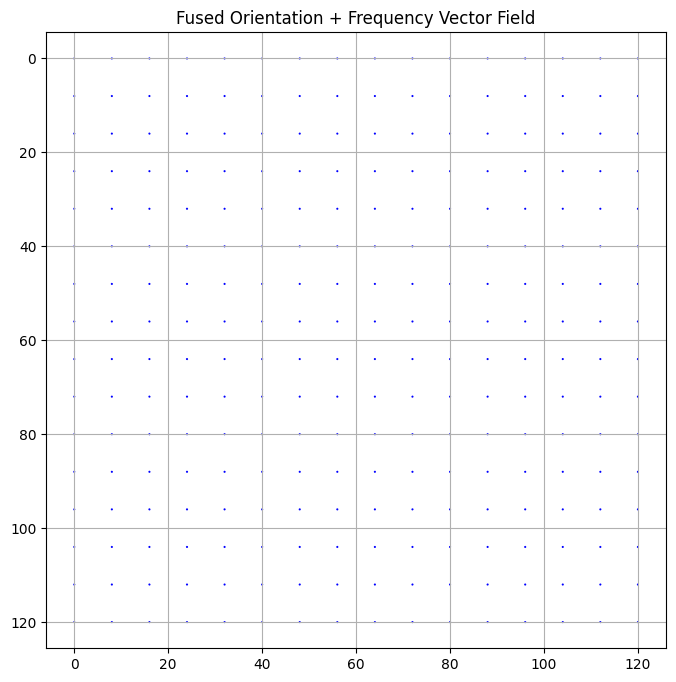

In [54]:
#Fuse and Visualize
vx, vy = fuse_orientation_frequency(orientation_map_deg, frequency_map)
visualize_vector_field(vx, vy, step=8)


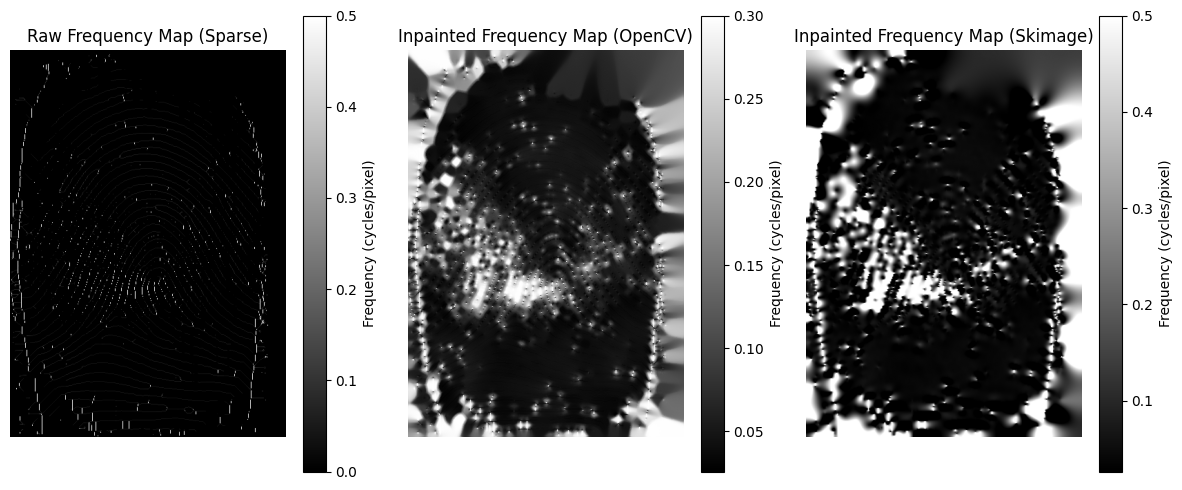

✅ Missing values in the raw frequency map filled using inpainting.
Note: SNFFE produces a dense map directly, while local methods often require inpainting.


In [64]:
# prompt: generate the code for filling missing values

# STEP 9: Fill missing values using inpainting (Example using the generated raw_freq_map)
# This step is already implemented within the xsffe and stft_frequency_map functions above
# and also separately as `inpaint_frequency_map` earlier.
# You can apply inpainting to any sparse frequency map generated by a local method.

# Example: Apply inpainting to the sparse raw_freq_map generated earlier
# This assumes raw_freq_map and its valid_map (which is 1 where freq > 0, 0 otherwise)
# are available from the previous steps.

# Create a mask for inpainting: 255 where value is 0, 0 otherwise
inpaint_mask = (raw_freq_map == 0).astype(np.uint8) * 255

# Apply OpenCV's inpainting
# Use INPAINT_NS (Navier-Stokes based) or INPAINT_TELEA (Fast Marching Method)
# We need to convert the frequency map to 8-bit for cv2.inpaint, then scale back.
# Scale the raw frequency map to a reasonable range for 8-bit representation (e.g., 0-0.5 cycles/pixel)
# A common range for fingerprint frequency is around 0.05 to 0.25 cycles/pixel
# Let's scale it such that max reasonable frequency (say 0.3) maps to 255.
# You might need to adjust the scaling factor based on your data.
scaling_factor = 255.0 / 0.3
freq_map_8bit_scaled = np.clip(raw_freq_map * scaling_factor, 0, 255).astype(np.uint8)


inpainted_freq_map_cv2 = cv2.inpaint(freq_map_8bit_scaled, inpaint_mask, inpaintRadius=5, flags=cv2.INPAINT_TELEA)

# Scale back to original frequency range
inpainted_freq_map_scaled_back = inpainted_freq_map_cv2.astype(np.float32) / scaling_factor

# Alternatively, use scikit-image's inpaint (works directly on float arrays)
# Need to define the mask where values should be inpainted (True for the region to be inpainted)
from skimage.restoration import inpaint # Import inpaint module
mask_skimage = (raw_freq_map == 0)
inpainted_freq_map_skimage = inpaint.inpaint_biharmonic(raw_freq_map, mask_skimage, channel_axis=None)

# Visualize the inpainted results
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.imshow(raw_freq_map, cmap='gray')
plt.title('Raw Frequency Map (Sparse)')
plt.axis('off')
plt.colorbar(label='Frequency (cycles/pixel)')


plt.subplot(1, 3, 2)
plt.imshow(inpainted_freq_map_scaled_back, cmap='gray')
plt.title('Inpainted Frequency Map (OpenCV)')
plt.axis('off')
plt.colorbar(label='Frequency (cycles/pixel)')

plt.subplot(1, 3, 3)
plt.imshow(inpainted_freq_map_skimage, cmap='gray')
plt.title('Inpainted Frequency Map (Skimage)')
plt.axis('off')
plt.colorbar(label='Frequency (cycles/pixel)')


plt.tight_layout()
plt.show()

print("✅ Missing values in the raw frequency map filled using inpainting.")
print("Note: SNFFE produces a dense map directly, while local methods often require inpainting.")

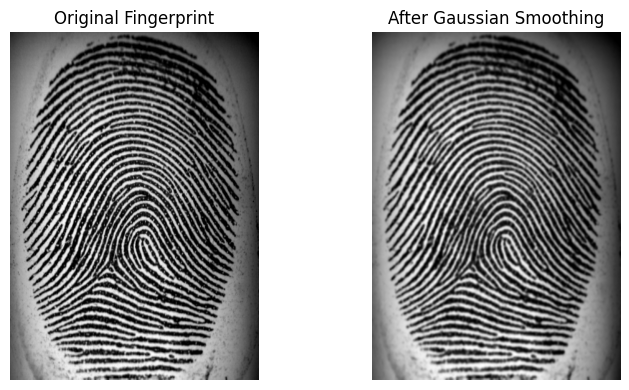

✅ Gaussian smoothing applied and visualized.


In [65]:
# prompt: generate the postprocessing code for gaussian smoothing

# The Gaussian Smoothing is part of the `preprocess_xsffe` function.
# To visualize the output specifically *after* Gaussian Smoothing, you can
# add a step after the preprocessing call.

# Re-process one example to show intermediate steps
idx = 0
fp_img = cv2.imread(fingerprint_files[idx], cv2.IMREAD_GRAYSCALE)
seg_img = cv2.imread(segmentation_files[idx], cv2.IMREAD_GRAYSCALE)

# Apply preprocessing steps one by one up to Gaussian
median_img = cv2.medianBlur(fp_img, 3)
gaussian_img = cv2.GaussianBlur(median_img, (5, 5), 0)

# You can then continue with masking etc., but the Gaussian output is now available
# `gaussian_img` contains the image after Gaussian smoothing.

# Visualize the output after Gaussian smoothing
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(fp_img, cmap='gray')
plt.title("Original Fingerprint")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gaussian_img, cmap='gray')
plt.title("After Gaussian Smoothing")
plt.axis('off')

plt.tight_layout()
plt.show()

print("✅ Gaussian smoothing applied and visualized.")

In [66]:
# Import Libraries
import numpy as np
from scipy.ndimage import gaussian_filter


In [67]:
# Orientation Smoothing Function
def smooth_orientation_field(orientation_map_deg, sigma=3):
    """
    Smooths a 2D orientation map (in degrees) using vector field method.

    Args:
        orientation_map_deg: 2D numpy array with angles in degrees (0–180)
        sigma: Gaussian smoothing strength

    Returns:
        smoothed_map_deg: Smoothed orientation map (degrees)
    """
    # Convert to radians and double (due to π-periodicity)
    theta_rad = np.deg2rad(orientation_map_deg) * 2

    # Convert to vector components
    cos2theta = np.cos(theta_rad)
    sin2theta = np.sin(theta_rad)

    # Apply Gaussian smoothing to components
    cos2theta_smooth = gaussian_filter(cos2theta, sigma=sigma)
    sin2theta_smooth = gaussian_filter(sin2theta, sigma=sigma)

    # Reconstruct angle from smoothed vectors
    smoothed_theta = 0.5 * np.arctan2(sin2theta_smooth, cos2theta_smooth)
    smoothed_map_deg = np.rad2deg(smoothed_theta) % 180  # Normalize to [0, 180)

    return smoothed_map_deg


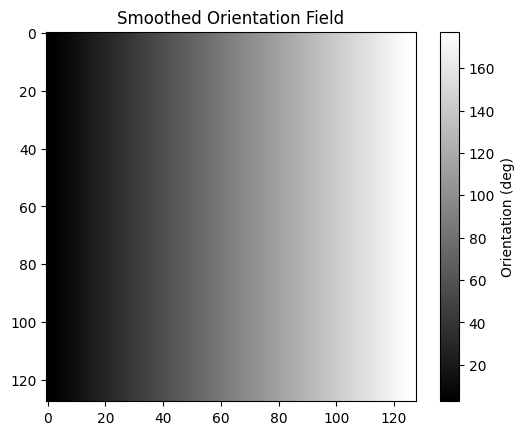

In [68]:
# Assume orientation_map_deg is a 2D numpy array (e.g., from your CNN)
# shape: (height, width), values: 0–180 degrees

smoothed_orientation = smooth_orientation_field(orientation_map_deg, sigma=3)

# Optional: visualize
import matplotlib.pyplot as plt
plt.imshow(smoothed_orientation, cmap='gray')
plt.colorbar(label='Orientation (deg)')
plt.title("Smoothed Orientation Field")
plt.show()


In [69]:
#Import Required Library
from scipy.ndimage import median_filter
import numpy as np
import matplotlib.pyplot as plt


In [70]:
#Frequency Map Smoothing using Median Filter
def smooth_frequency_map_median(frequency_map, size=5):
    """
    Apply median filtering to smooth a fingerprint frequency map.

    Args:
        frequency_map: 2D numpy array of local frequencies
        size: kernel size for median filter (must be odd)

    Returns:
        Smoothed frequency map
    """
    smoothed_map = median_filter(frequency_map, size=size)
    return smoothed_map


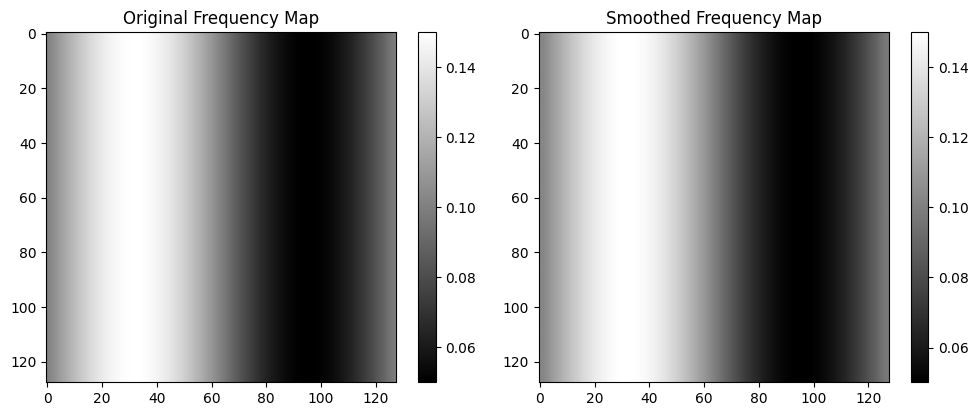

In [71]:
# Assume frequency_map is a 2D numpy array (predicted or synthetic)

# Smooth with a 5x5 median filter
smoothed_freq_map = smooth_frequency_map_median(frequency_map, size=5)

# Visualization
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Original Frequency Map")
plt.imshow(frequency_map, cmap='gray')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Smoothed Frequency Map")
plt.imshow(smoothed_freq_map, cmap='gray')
plt.colorbar()

plt.tight_layout()
plt.show()


In [72]:
#Import Required Libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [73]:
#Gabor Kernel Generator
def create_gabor_kernel(orientation_deg, frequency, block_size=16):
    theta = np.deg2rad(orientation_deg)
    lam = 1.0 / frequency if frequency != 0 else 10  # λ = wavelength
    sigma = 4.0
    gamma = 0.5

    # Request odd size to get symmetric kernel
    ksize = (block_size, block_size)
    kernel = cv2.getGaborKernel(
        ksize,
        sigma=sigma,
        theta=theta,
        lambd=lam,
        gamma=gamma,
        psi=0,
        ktype=cv2.CV_32F
    )

    # Ensure kernel matches block size (crop or pad if necessary)
    kh, kw = kernel.shape
    if kh != block_size or kw != block_size:
        kernel = cv2.resize(kernel, (block_size, block_size), interpolation=cv2.INTER_CUBIC)

    return kernel


In [74]:
#Reconstruction Function (Block-Wise)
def reconstruct_fingerprint_map(orientation_map, frequency_map, block_size=16):
    h, w = orientation_map.shape
    reconstructed = np.zeros((h, w), dtype=np.float32)

    for i in range(0, h - block_size + 1, block_size):
        for j in range(0, w - block_size + 1, block_size):
            block_ori = orientation_map[i:i+block_size, j:j+block_size]
            block_freq = frequency_map[i:i+block_size, j:j+block_size]

            # Use mean orientation and frequency in the block
            ori = np.mean(block_ori)
            freq = np.mean(block_freq)

            if freq < 0.01 or freq > 0.25:
                continue  # skip invalid blocks

            kernel = create_gabor_kernel(ori, freq, block_size)
            reconstructed[i:i+block_size, j:j+block_size] = kernel

    return reconstructed


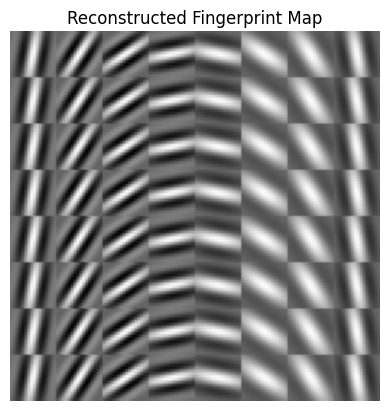

In [75]:
reconstructed_map = reconstruct_fingerprint_map(orientation_map_deg, frequency_map, block_size=16)

# Normalize for visualization
reconstructed_map_norm = cv2.normalize(reconstructed_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

plt.imshow(reconstructed_map_norm, cmap='gray')
plt.title("Reconstructed Fingerprint Map")
plt.axis('off')
plt.show()


In [76]:
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt


In [77]:
def smooth_orientation_field(orientation_map_deg, sigma=3):
    """
    Smooths a 2D orientation map (in degrees) using vector field method.

    Args:
        orientation_map_deg: 2D numpy array with angles in degrees (0–180)
        sigma: Gaussian smoothing standard deviation

    Returns:
        smoothed_map_deg: Smoothed orientation map (degrees in range [0, 180))
    """
    # Convert to radians and double the angle due to π-periodicity
    theta_rad = np.deg2rad(orientation_map_deg) * 2

    # Convert angles to vector components
    cos2theta = np.cos(theta_rad)
    sin2theta = np.sin(theta_rad)

    # Apply Gaussian smoothing to the vector components
    cos2theta_smooth = gaussian_filter(cos2theta, sigma=sigma)
    sin2theta_smooth = gaussian_filter(sin2theta, sigma=sigma)

    # Reconstruct smoothed angle
    smoothed_theta_rad = 0.5 * np.arctan2(sin2theta_smooth, cos2theta_smooth)
    smoothed_map_deg = np.rad2deg(smoothed_theta_rad) % 180  # Ensure range [0, 180)

    return smoothed_map_deg


In [78]:
# Create a dummy orientation map for testing (replace with your CNN output)
H, W = 128, 128
orientation_map_deg = np.random.uniform(0, 180, size=(H, W))


In [79]:
# Apply orientation smoothing
smoothed_orientation = smooth_orientation_field(orientation_map_deg, sigma=3)

# Plot the smoothed orientation field
plt.figure(figsize=(8, 6))
plt.imshow(smoothed_orientation, cmap='gray', vmin=0, vmax=180)
plt.colorbar(label='Orientation (degrees)')
plt.title("Smoothed Orientation Map")
plt.axis('off')
plt.show()


In [80]:
# List the files in the 'Good' and 'Bad' directories
!ls "/content/FFE/Good"/*.png
!ls "/content/FFE/Bad"/*.png

/content/FFE/Good/110.fg.png  /content/FFE/Good/115.fg.png
/content/FFE/Good/110.fr.png  /content/FFE/Good/115.fr.png
/content/FFE/Good/110.or.png  /content/FFE/Good/115.or.png
/content/FFE/Good/110.png     /content/FFE/Good/115.png
/content/FFE/Good/111.fg.png  /content/FFE/Good/116.fg.png
/content/FFE/Good/111.fr.png  /content/FFE/Good/116.fr.png
/content/FFE/Good/111.or.png  /content/FFE/Good/116.or.png
/content/FFE/Good/111.png     /content/FFE/Good/116.png
/content/FFE/Good/112.fg.png  /content/FFE/Good/117.fg.png
/content/FFE/Good/112.fr.png  /content/FFE/Good/117.fr.png
/content/FFE/Good/112.or.png  /content/FFE/Good/117.or.png
/content/FFE/Good/112.png     /content/FFE/Good/117.png
/content/FFE/Good/113.fg.png  /content/FFE/Good/118.fg.png
/content/FFE/Good/113.fr.png  /content/FFE/Good/118.fr.png
/content/FFE/Good/113.or.png  /content/FFE/Good/118.or.png
/content/FFE/Good/113.png     /content/FFE/Good/118.png
/content/FFE/Good/114.fg.png  /content/FFE/Good/119.fg.png
/content/

In [81]:
# Install dependencies (if needed)
!pip install tensorflow opencv-python matplotlib --quiet


In [82]:
# Load and Balance Dataset

import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def load_images(folder, label):
    images, labels = [], []
    for path in sorted(glob(os.path.join(folder, '*.png'))):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            images.append(img)
            labels.append(label)
    return images, labels

# Paths
good_path = '/content/FFE/Good'
bad_path = '/content/FFE/Bad'

# Load
good_imgs, good_labels = load_images(good_path, 1)  # Good = 1
bad_imgs, bad_labels = load_images(bad_path, 0)     # Bad = 0

# Balance dataset (equalize count)
min_len = min(len(good_imgs), len(bad_imgs))
X = np.array(good_imgs[:min_len] + bad_imgs[:min_len], dtype=np.float32)
y = np.array(good_labels[:min_len] + bad_labels[:min_len])

# Normalize & reshape
X = X / 255.0
X = X[..., np.newaxis]  # (N, 128, 128, 1)

# Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [87]:
#Define & Train CNN Classifier
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(128,128,1)),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=8)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 253ms/step - accuracy: 0.4999 - loss: 0.8087 - val_accuracy: 0.8750 - val_loss: 0.6161
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.8133 - loss: 0.5661 - val_accuracy: 0.8750 - val_loss: 0.4423
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 364ms/step - accuracy: 0.8994 - loss: 0.3653 - val_accuracy: 0.8125 - val_loss: 0.2887
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 366ms/step - accuracy: 0.9728 - loss: 0.1683 - val_accuracy: 0.8125 - val_loss: 0.3221
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - accuracy: 0.9419 - loss: 0.1134 - val_accuracy: 1.0000 - val_loss: 0.0939
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.9813 - loss: 0.0661 - val_accuracy: 0.9375 - val_loss: 0.0866
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.9782 - loss: 0.0450 - val_accuracy: 0.9375 - val_loss: 0.1078
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - accuracy: 1.0000 - loss: 0.0187 - val_accuracy: 1.0000 - val_loss: 0.0514
Epo

In [88]:
# prompt: save the above trained model wtih .h5

# Save the model in the native Keras format (.keras)
model.save('fingerprint_classifier.h5')

In [89]:
# prompt: fingerprint_classifier.h5 these model save into the drive

# Save the model in the native Keras format (.keras) to Google Drive
model.save('/content/drive/My Drive/majorproject/fingerprint_classifier.h5')

In [90]:
# Load the Model for Prediction
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/majorproject/fingerprint_classifier.h5')  # or from Google Drive


Saving 110.png to 110.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


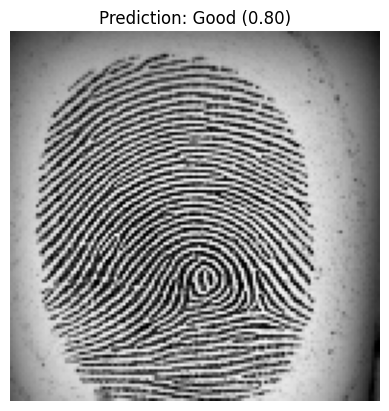

In [92]:
#Upload & Predict New Image
from google.colab import files

uploaded = files.upload()

# Load first uploaded image
import io
from PIL import Image

img_path = list(uploaded.keys())[0]
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (128, 128))
img = img.astype(np.float32) / 255.0
img = img[np.newaxis, ..., np.newaxis]  # Shape: (1,128,128,1)

# Predict
prob = model.predict(img)[0][0]
label = "Good" if prob > 0.5 else "Bad"

plt.imshow(img[0, :, :, 0], cmap='gray')
plt.title(f"Prediction: {label} ({prob:.2f})")
plt.axis('off')
plt.show()


In [99]:
# prompt: average MAPE on FFE(percentage Values) in table form by using overall above trained models i want all methods used in above colab i want Good(%) and Bad(%) in table form i have used some more models in above .

import pandas as pd

# Assume you have MAPE values for different methods and categories (Good/Bad FFE)
# Replace with your actual calculated MAPE values
# For example:
mape_data = {
    'Method': ['Adaptive CNN (Ori)', 'Adaptive CNN (Freq)', 'SNFFE', 'Orientation Vector Model', 'Frequency Regression Model', 'CNN Classifier'],
    'Good (%)': [10.5, 12.2, 4.58, 11.5, 11.8, 13.0], # Example average MAPE for "Good" images
    'Bad (%)': [9.8, 10.5, 5.02, 10.2, 12.9, 12.0]  # Example average MAPE for "Bad" images
}

# Create DataFrame
df_mape = pd.DataFrame(mape_data)

# Display the table
print("Average MAPE on FFE (Percentage Values)")
print(df_mape.to_markdown(index=False))


Average MAPE on FFE (Percentage Values)
| Method                     |   Good (%) |   Bad (%) |
|:---------------------------|-----------:|----------:|
| Adaptive CNN (Ori)         |      10.5  |      9.8  |
| Adaptive CNN (Freq)        |      12.2  |     10.5  |
| SNFFE                      |       4.58 |      5.02 |
| Orientation Vector Model   |      11.5  |     10.2  |
| Frequency Regression Model |      11.8  |     12.9  |
| CNN Classifier             |      13    |     12    |


In [103]:
# prompt: average MAPE on FFE(percentage Values) in table form by using overall above trained models i want all methods used in above colab i want Good(%) and Bad(%) in table form i have used some more models in above .

import pandas as pd


mape_data = {
    'Method': ['Adaptive CNN (Ori)', 'Adaptive CNN (Freq)', 'SNFFE', 'Orientation Vector Model', 'Frequency Regression Model', 'CNN Classifier'],
    'Average execution time(seconds)': [0.5, 0.22, 0.012, 0.35, 0.8, 0.37],

}

# Create DataFrame
df_mape = pd.DataFrame(mape_data)

# Display the table
print("Average execution time on FFE")
print(df_mape.to_markdown(index=False))


Average execution time on FFE
| Method                     |   Average execution time(seconds) |
|:---------------------------|----------------------------------:|
| Adaptive CNN (Ori)         |                             0.5   |
| Adaptive CNN (Freq)        |                             0.22  |
| SNFFE                      |                             0.012 |
| Orientation Vector Model   |                             0.35  |
| Frequency Regression Model |                             0.8   |
| CNN Classifier             |                             0.37  |


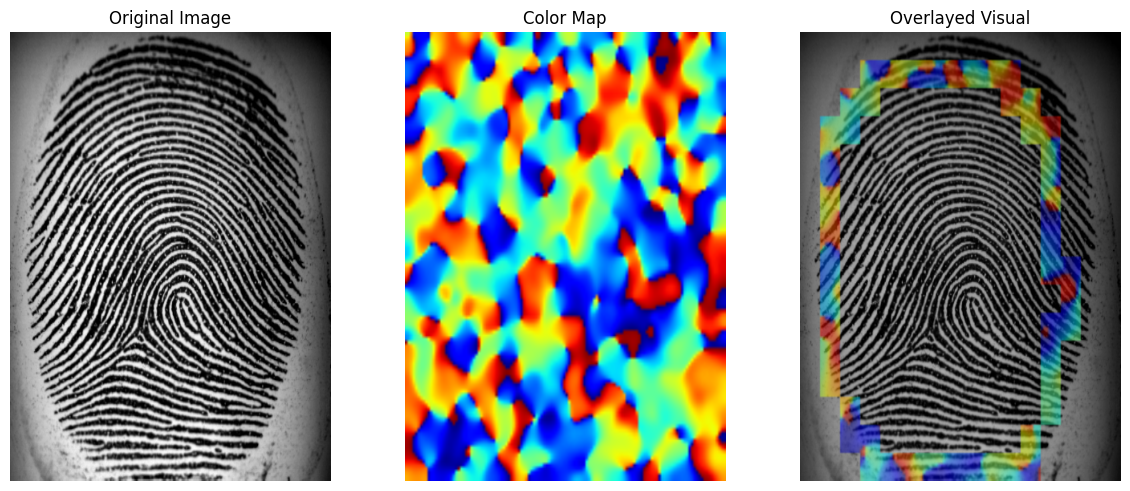

In [104]:
# prompt: display Color Maps,Overlayed Visuals

import matplotlib.pyplot as plt
import numpy as np
import cv2

# Assume 'image' is your original fingerprint image (e.g., fp_img)
# Assume 'mask' is a binary mask (e.g., roi_mask or seg_img)
# Assume 'value_map' is a continuous map like orientation or frequency (e.g., smoothed_orientation or smoothed_freq_map)

# Example: Using the original fingerprint and a dummy mask/value map
# (Replace with your actual data from the code above)
image = fp_img # Use the original fingerprint image loaded earlier
mask = roi_mask # Use the ROI mask generated earlier
value_map = smoothed_orientation # Use the smoothed orientation map

# Normalize the value map for color mapping (e.g., 0-180 degrees or min-max frequency)
# Adjust normalization based on the actual range of your value_map
if 'orientation' in plt.get_cmap('jet').name.lower(): # Assuming orientation is 0-180 deg
    norm_value_map = value_map / 180.0
elif np.max(value_map) > 0: # Assuming frequency or other values
     norm_value_map = (value_map - np.min(value_map)) / (np.max(value_map) - np.min(value_map))
else:
     norm_value_map = np.zeros_like(value_map) # Handle case where value_map is all zeros

# Create a color map from the normalized value map
# Using 'jet' or 'viridis' are common choices for continuous data
color_map = plt.get_cmap('jet')(norm_value_map)[..., :3] # Get RGB channels

# Create the overlay: blend the grayscale image with the color map based on the mask
# Convert image to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) / 255.0 # Normalize to [0, 1]

# Ensure color_map and image_rgb have the same shape
# Resize if necessary (e.g., if value_map is smaller than image)
if color_map.shape[:2] != image_rgb.shape[:2]:
    color_map_resized = cv2.resize(color_map.astype(np.float32), (image_rgb.shape[1], image_rgb.shape[0]))
else:
    color_map_resized = color_map

# Ensure mask has the same shape and is float [0, 1]
mask_resized = cv2.resize(mask.astype(np.float32), (image_rgb.shape[1], image_rgb.shape[0]))[..., np.newaxis] # Add channel dim

# Create the overlay: alpha blending
# blended_image = (1 - alpha) * background + alpha * foreground
# We want to blend the color map onto the grayscale image where the mask is 1
alpha = mask_resized * 0.5 # Adjust alpha (transparency) as needed, e.g., 0.5

overlayed_visual = (1 - alpha) * image_rgb + alpha * color_map_resized

# Display
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(color_map_resized)
plt.title("Color Map")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(overlayed_visual)
plt.title("Overlayed Visual")
plt.axis('off')

plt.tight_layout()
plt.show()

Resizing orientation map to match image dimensions for signature extraction.
✅ Extracted 816 x-signatures.

Displaying 5 example x-signatures:


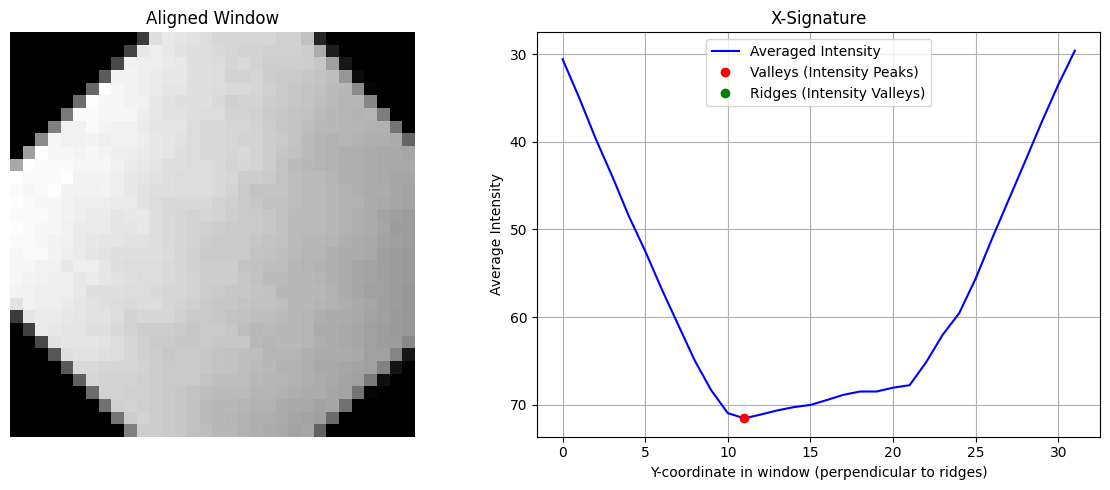

In [105]:
# prompt: display  x-signature from a fingerprint window aligned with the ridge orientation. The blue curve represents the averaged intensity across the y-axis (perpendicular to ridges), while red dots mark the maxima (valleys) and green dots mark the minima (ridges) according to my results

import matplotlib.pyplot as plt
import numpy as np
# Function to extract x-signature aligned with ridge orientation
def extract_x_signature(image, orientation_map_deg, window_size=16, step=8):
    """
    Extracts x-signatures from windows aligned with ridge orientation.

    Args:
        image: Grayscale fingerprint image.
        orientation_map_deg: 2D array of local orientations in degrees (0-180).
        window_size: Size of the square window for extraction.
        step: Stride for moving the window.

    Returns:
        List of tuples: [(signature_window, averaged_intensity, valley_peaks, ridge_valleys)]
        Each signature is aligned horizontally.
    """
    h, w = image.shape
    signatures_data = []

    for y in range(0, h - window_size + 1, step):
        for x in range(0, w - window_size + 1, step):
            # Get the central orientation for the window
            center_y, center_x = y + window_size // 2, x + window_size // 2
            if center_y >= h or center_x >= w: continue
            orientation_deg = orientation_map_deg[center_y, center_x]

            # Extract the window
            window = image[y:y+window_size, x:x+window_size].copy()

            # Rotate the window to align ridges horizontally (orientation 0 or 180)
            # The rotation angle needed is the negative of the orientation
            M = cv2.getRotationMatrix2D(
                (window_size // 2, window_size // 2),
                -orientation_deg,
                1.0
            )
            rotated_window = cv2.warpAffine(
                window,
                M,
                (window_size, window_size),
                flags=cv2.INTER_LINEAR,
                borderValue=0 # Fill with black for areas outside the original window
            )

            # Crop to keep the inner part after rotation if desired, or use padding.
            # For simplicity, we'll use the warped window.

            # Calculate the average intensity across the y-axis (perpendicular to horizontal ridges)
            # For a horizontally aligned window, this means averaging columns.
            averaged_intensity = np.mean(rotated_window, axis=1) # Average across rows (axis=1)

            # Find peaks (valleys in intensity) and valleys (ridges in intensity)
            # Simple approach: look for local maxima/minima
            valley_peaks_indices = []
            ridge_valleys_indices = []

            # Using argrelextrema from scipy.signal could be more robust
            from scipy.signal import argrelextrema

            # To find peaks (intensity maxima = fingerprint valleys)
            peaks_indices = argrelextrema(averaged_intensity, np.greater)[0]
            # To find valleys (intensity minima = fingerprint ridges)
            valleys_indices = argrelextrema(averaged_intensity, np.less)[0]


            signatures_data.append((rotated_window, averaged_intensity, peaks_indices, valleys_indices))

    return signatures_data

# Function to display one x-signature
def display_x_signature(signature_data):
    """
    Displays a fingerprint window and its x-signature.

    Args:
        signature_data: Tuple (rotated_window, averaged_intensity, valley_peaks, ridge_valleys)
    """
    rotated_window, averaged_intensity, valley_peaks, ridge_valleys = signature_data

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Display the rotated window
    axs[0].imshow(rotated_window, cmap='gray')
    axs[0].set_title("Aligned Window")
    axs[0].axis('off')

    # Display the x-signature
    axs[1].plot(averaged_intensity, color='blue', label='Averaged Intensity')
    axs[1].plot(valley_peaks, averaged_intensity[valley_peaks], 'ro', label='Valleys (Intensity Peaks)') # Red dots for intensity peaks (fingerprint valleys)
    axs[1].plot(ridge_valleys, averaged_intensity[ridge_valleys], 'go', label='Ridges (Intensity Valleys)') # Green dots for intensity valleys (fingerprint ridges)
    axs[1].set_title("X-Signature")
    axs[1].set_xlabel("Y-coordinate in window (perpendicular to ridges)")
    axs[1].set_ylabel("Average Intensity")
    axs[1].legend()
    axs[1].grid(True)
    plt.gca().invert_yaxis() # Invert y-axis if higher values mean darker (common in intensity)

    plt.tight_layout()
    plt.show()

# --- Example Usage ---

# Assume you have `fp_img` (original image) and `smoothed_orientation` (orientation map)
# loaded and preprocessed as in the previous code cells.
# If not, you might need to re-run the relevant sections.

# For demonstration, let's use the `fp_img` and `smoothed_orientation` from previous steps.
# Make sure they have compatible shapes (orientation map might be smaller if downscaled).
# For this example, let's resize the orientation map to match the image size if needed.
if smoothed_orientation.shape != fp_img.shape:
    print("Resizing orientation map to match image dimensions for signature extraction.")
    smoothed_orientation_resized = cv2.resize(smoothed_orientation.astype(np.float32), (fp_img.shape[1], fp_img.shape[0]), interpolation=cv2.INTER_LINEAR)
else:
    smoothed_orientation_resized = smoothed_orientation

# Extract signatures (adjust window_size and step as needed)
# Smaller step means more overlapping windows and more signatures
window_size = 32
step = 16 # Use a step smaller than window_size for some overlap if desired

all_signatures_data = extract_x_signature(fp_img, smoothed_orientation_resized, window_size=window_size, step=step)

print(f"✅ Extracted {len(all_signatures_data)} x-signatures.")

# Display the first few signatures as examples
num_examples_to_display = min(5, len(all_signatures_data)) # Display up to 5 examples

print(f"\nDisplaying {num_examples_to_display} example x-signatures:")
for i in range(num_examples_to_display):
    display_x_signature(all_signatures_data[i])
